In [25]:
import os
import json
import time
import math
import random
from datetime import datetime, timedelta
from typing import List, Dict, Optional


import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prerequisites & helper

In [2]:
# What I do: load environment variables if present (so API tokens can be kept out of code)

In [5]:
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
# python-dotenv is optional. If not installed, env vars can still be set by OS.
    pass


FB_PAGE_ID = os.getenv('FB_PAGE_ID')
FB_ACCESS_TOKEN = os.getenv('FB_ACCESS_TOKEN')
IG_USER_ID = os.getenv('IG_USER_ID')
IG_ACCESS_TOKEN = os.getenv('IG_ACCESS_TOKEN')
LINKEDIN_ORG_URN = os.getenv('LINKEDIN_ORG_URN')
LINKEDIN_ACCESS_TOKEN = os.getenv('LINKEDIN_ACCESS_TOKEN')


GRAPH_BASE = "https://graph.facebook.com" # Meta Graph API base

# Step 1 — API fetch helpers

In [6]:
#What I do: create small, robust functions that attempt to call each platform API

In [10]:
def safe_request_get(url, params=None, headers=None, timeout=10):
    try:
        r = requests.get(url, params=params, headers=headers, timeout=timeout)
        r.raise_for_status()
        return r.json()
    except Exception as e:
        print(f"[safe_request_get] request failed: {e} -> url={url}")
        return None

In [11]:

# --- Facebook Page posts + insights

In [13]:
def fetch_facebook_post_metrics(post_id: str, access_token: str):
    """
    What I do: fetch metrics (likes, comments, shares, reach) for a given post
    Why: needed to analyze engagement per post
    """
    if not post_id or not access_token:
        print("[Facebook] No post_id or access_token provided — skipping metrics fetch.")
        return {}

    url = f"{GRAPH_BASE}/v17.0/{post_id}/insights"
    params = {
        "metric": "post_impressions,post_engaged_users,post_reactions_like_total,post_shares,post_comments",
        "access_token": access_token
    }

    j = safe_request_get(url, params=params)
    if not j or 'data' not in j:
        return {}

    metrics = {m['name']: m['values'][0]['value'] for m in j.get('data', []) if 'values' in m}
    return metrics


In [14]:
# --- Instagram Business (via Meta Graph API)

def fetch_instagram_media(ig_user_id: str, access_token: str, limit: int = 50) -> pd.DataFrame:
    """
    What I do: fetch media for IG Business account with basic fields (like_count, comments_count)
    Why: these fields directly provide likes and comments for each post
    """
    if not ig_user_id or not access_token:
        print("[Instagram] No IG user id or access token — skipping Instagram fetch.")
        return pd.DataFrame()

    url = f"{GRAPH_BASE}/v17.0/{ig_user_id}/media"
    params = {
        'access_token': access_token,
        'fields': 'id,caption,media_type,permalink,timestamp,like_count,comments_count',
        'limit': limit
    }
    j = safe_request_get(url, params=params)
    if not j or 'data' not in j:
        return pd.DataFrame()

    rows = []
    for m in j.get('data', []):
        rows.append({
            'platform': 'instagram',
            'post_id': m.get('id'),
            'created_time': m.get('timestamp'),
            'message': m.get('caption'),
            'permalink': m.get('permalink'),
            'likes': m.get('like_count', 0),
            'comments': m.get('comments_count', 0),
            'media_type': m.get('media_type')
        })
    return pd.DataFrame(rows)


def fetch_instagram_media_insights(media_id: str, access_token: str, metrics: List[str]) -> Dict:
    """
    What I do: fetch insights (reach, impressions, saves, etc.) for a given Instagram media post
    Why: helps measure performance beyond just likes and comments
    """
    if not media_id or not access_token:
        return {}

    url = f"{GRAPH_BASE}/v17.0/{media_id}/insights"
    params = {'access_token': access_token, 'metric': ','.join(metrics)}
    j = safe_request_get(url, params=params)
    if not j or 'data' not in j:
        return {}

    out = {}
    for item in j.get('data', []):
        out[item.get('name')] = item.get('values', [{}])[-1].get('value')
    return out


In [15]:
# --- LinkedIn

def fetch_linkedin_org_posts(org_urn: str, access_token: str) -> pd.DataFrame:
    """
    What I do: fetch organization UGC posts (if permissions allow) from LinkedIn
    Why: we need post-level message and created time; socialActions endpoint gives likes/comments
    NOTE: LinkedIn API access is more restricted; provide tokens and ensure correct product access
    """
    if not org_urn or not access_token:
        print("[LinkedIn] No org URN or access token — skipping LinkedIn fetch.")
        return pd.DataFrame()

    headers = {
        "Authorization": f"Bearer {access_token}",
        "X-Restli-Protocol-Version": "2.0.0"
    }
    url = "https://api.linkedin.com/v2/ugcPosts"
    params = {"q": "authors", "authors": f"List({org_urn})", "sortBy": "CREATED"}

    j = safe_request_get(url, params=params, headers=headers)
    if not j or 'elements' not in j:
        return pd.DataFrame()

    rows = []
    for p in j.get('elements', []):
        # created time is in milliseconds
        created = None
        try:
            created_ms = p.get('created', {}).get('time')
            if created_ms:
                created = datetime.utcfromtimestamp(created_ms / 1000).isoformat()
        except Exception:
            created = None

        text = (
            p.get('specificContent', {})
             .get('com.linkedin.ugc.ShareContent', {})
             .get('shareCommentary', {})
             .get('text')
        )
        urn = p.get('id') or p.get('activity') or p.get('id')

        rows.append({
            'platform': 'linkedin',
            'post_id': urn,
            'created_time': created,
            'message': text,
            'permalink': None
        })
    return pd.DataFrame(rows)


def fetch_linkedin_social_actions(activity_urn: str, access_token: str) -> Dict:
    """
    What I do: call socialActions endpoint to get counts like reactionSummary, commentSummary
    Why: LinkedIn stores likes/comments per content under socialActions
    """
    if not activity_urn or not access_token:
        return {}

    headers = {
        "Authorization": f"Bearer {access_token}",
        "X-Restli-Protocol-Version": "2.0.0"
    }
    # Example endpoint (activity URN from ugcPosts):
    url = f"https://api.linkedin.com/v2/socialActions/{activity_urn}"

    j = safe_request_get(url, headers=headers)
    if not j:
        return {}

    # The structure varies; we attempt to pull counts if present
    out = {}
    out['likeCount'] = (
        j.get('reactionSummary', {}).get('count')
        if isinstance(j.get('reactionSummary'), dict)
        else None
    )
    out['commentCount'] = (
        j.get('commentSummary', {}).get('count')
        if isinstance(j.get('commentSummary'), dict)
        else None
    )
    return out

# Step 2 — Demo dataset generator (guarantees immediate outputs)

In [16]:
# What I do: create a small synthetic dataset representing posts across the three platforms

In [28]:
def create_demo_dataset(n_days: int = 60, posts_per_day: int = 2, seed: int = 42) -> pd.DataFrame:
    random.seed(seed)
    np.random.seed(seed)
    rows = []
    platforms = ['facebook', 'instagram', 'linkedin']
    media_types = ['image', 'video', 'text', 'link']
    start = datetime.now() - timedelta(days=n_days)
    post_counter = 0
    for day in range(n_days):
        for _ in range(posts_per_day):
            dt = start + timedelta(days=day, hours=random.randint(8,22), minutes=random.randint(0,59))
            platform = random.choice(platforms)
            media_type = random.choice(media_types)

            # Simulate audience size differences
            if platform == 'facebook':
                reach = int(abs(np.random.normal(1200, 600))) + 50
            elif platform == 'instagram':
                reach = int(abs(np.random.normal(800, 400))) + 30
            else:
                reach = int(abs(np.random.normal(600, 300))) + 20

            # engagement rates vary
            base_rate = 0.03 if platform == 'facebook' else (0.05 if platform == 'instagram' else 0.04)
            if media_type == 'video':
                base_rate += 0.02

            likes = max(0, int(reach * base_rate * np.random.uniform(0.6,1.6)))
            comments = max(0, int(likes * np.random.uniform(0.05,0.25)))
            shares = max(0, int(likes * np.random.uniform(0.03,0.1)))

            rows.append({
                'platform': platform,
                'post_id': f'demo_{post_counter}',
                'created_time': dt.isoformat(),
                'message': f"Demo post {post_counter} on {platform} ({media_type})",
                'likes': likes,
                'comments': comments,
                'shares': shares,
                'reach': reach,
                'media_type': media_type,
                'permalink': None
            })
            post_counter += 1
    df = pd.DataFrame(rows)
    return df

In [29]:
df = create_demo_dataset(n_days=30, posts_per_day=3)
print(df.shape)
print(df.head())

(90, 10)
   platform post_id                created_time  \
0  facebook  demo_0  2025-08-16T07:22:50.261980   
1  facebook  demo_1  2025-08-16T00:29:50.261980   
2  linkedin  demo_2  2025-08-16T08:02:50.261980   
3  facebook  demo_3  2025-08-17T06:42:50.261980   
4  facebook  demo_4  2025-08-16T22:28:50.261980   

                           message  likes  comments  shares  reach media_type  \
0   Demo post 0 on facebook (text)     61        10       2   1548       text   
1  Demo post 1 on facebook (image)     26         1       2   1167      image   
2  Demo post 2 on linkedin (image)     27         6       2   1093      image   
3  Demo post 3 on facebook (image)     41         3       1   1710      image   
4  Demo post 4 on facebook (image)     43         4       3   1395      image   

  permalink  
0      None  
1      None  
2      None  
3      None  
4      None  


# Normalization & Feature Engineering

In [18]:
#What I do: unify column names across platforms and create derived metrics

In [45]:
def normalize_and_engineer(df: pd.DataFrame) -> pd.DataFrame:
    """
    What I do: clean, normalize, and engineer new features from raw social media data
    Why: ensures consistent numeric types and adds engagement metrics + time features
    """
    df = df.copy()

    # Ensure expected columns exist
    for c in ['likes', 'comments', 'shares', 'reach', 'impressions']:
        if c not in df.columns:
            df[c] = 0

    # Numeric conversion
    df['likes'] = pd.to_numeric(df['likes'], errors='coerce').fillna(0).astype(int)
    df['comments'] = pd.to_numeric(df['comments'], errors='coerce').fillna(0).astype(int)
    df['shares'] = pd.to_numeric(df['shares'], errors='coerce').fillna(0).astype(int)
    df['reach'] = pd.to_numeric(df['reach'], errors='coerce').fillna(0).astype(int)

    # Engagement and rate
    df['engagement'] = df['likes'] + df['comments'] + df['shares']
    # Avoid divide by zero — mark as NaN where reach is zero
    df['engagement_rate'] = np.where(df['reach'] > 0, df['engagement'] / df['reach'], np.nan)

    # Time features
    df['created_time'] = pd.to_datetime(df['created_time'], errors='coerce')
    df['date'] = df['created_time'].dt.date
    df['hour'] = df['created_time'].dt.hour
    df['dow'] = df['created_time'].dt.day_name()

    return df
# 1. Normalize data
df = normalize_and_engineer(df)

# Analysis & Visualization

In [20]:
#What I do: provide a set of functions that compute the exact items your instructor asked for
# - likes, shares, comments, reach (already in normalized DF)

In [33]:
def platform_summary(df: pd.DataFrame) -> pd.DataFrame:
    s = df.groupby('platform').agg(
        total_engagement=('engagement', 'sum'),
        avg_engagement_rate=('engagement_rate', 'mean'),
        num_posts=('post_id', 'count'),
        avg_reach=('reach', 'mean')
    ).reset_index()
    return s


def weekly_trend_plot(df: pd.DataFrame, savepath: Optional[str] = None):
    df2 = df.set_index('created_time').groupby('platform').resample('W')['engagement'].sum().unstack(0).fillna(0)
    plt.figure(figsize=(12, 5))
    for col in df2.columns:
        plt.plot(df2.index, df2[col], marker='o', label=col)
    plt.title('Weekly Engagement Trend by Platform')
    plt.ylabel('Engagement (likes+comments+shares)')
    plt.xlabel('Week')
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()   # 👈 ensures the plot is displayed


def top_posts(df: pd.DataFrame, n: int = 10) -> pd.DataFrame:
    return df.sort_values('engagement_rate', ascending=False).head(n)[[
        'platform', 'post_id', 'created_time', 'message',
        'likes', 'comments', 'shares', 'reach',
        'engagement', 'engagement_rate', 'permalink'
    ]]


def heatmap_day_hour(df: pd.DataFrame, savepath: Optional[str] = None):
    # Pivot to get average engagement_rate by day of week and hour
    pivot = df.pivot_table(index='dow', columns='hour', values='engagement_rate', aggfunc='mean')
    
    # Reorder days
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot = pivot.reindex(days)
    
    plt.figure(figsize=(14, 4))
    plt.imshow(pivot, aspect='auto')
    plt.colorbar(label='Avg engagement_rate')
    plt.xticks(range(0, 24), range(0, 24))
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.title('Average Engagement Rate by Day (rows) and Hour (columns)')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()   # 👈 ensures heatmap is displayed
    
    return pivot

✅ Dataset shape: (90, 16)
   platform post_id               created_time  \
0  facebook  demo_0 2025-08-16 07:22:50.261980   
1  facebook  demo_1 2025-08-16 00:29:50.261980   
2  linkedin  demo_2 2025-08-16 08:02:50.261980   
3  facebook  demo_3 2025-08-17 06:42:50.261980   
4  facebook  demo_4 2025-08-16 22:28:50.261980   

                           message  likes  comments  shares  reach media_type  \
0   Demo post 0 on facebook (text)     61        10       2   1548       text   
1  Demo post 1 on facebook (image)     26         1       2   1167      image   
2  Demo post 2 on linkedin (image)     27         6       2   1093      image   
3  Demo post 3 on facebook (image)     41         3       1   1710      image   
4  Demo post 4 on facebook (image)     43         4       3   1395      image   

  permalink  impressions  engagement  engagement_rate        date  hour  \
0      None            0          73         0.047158  2025-08-16     7   
1      None            0          29

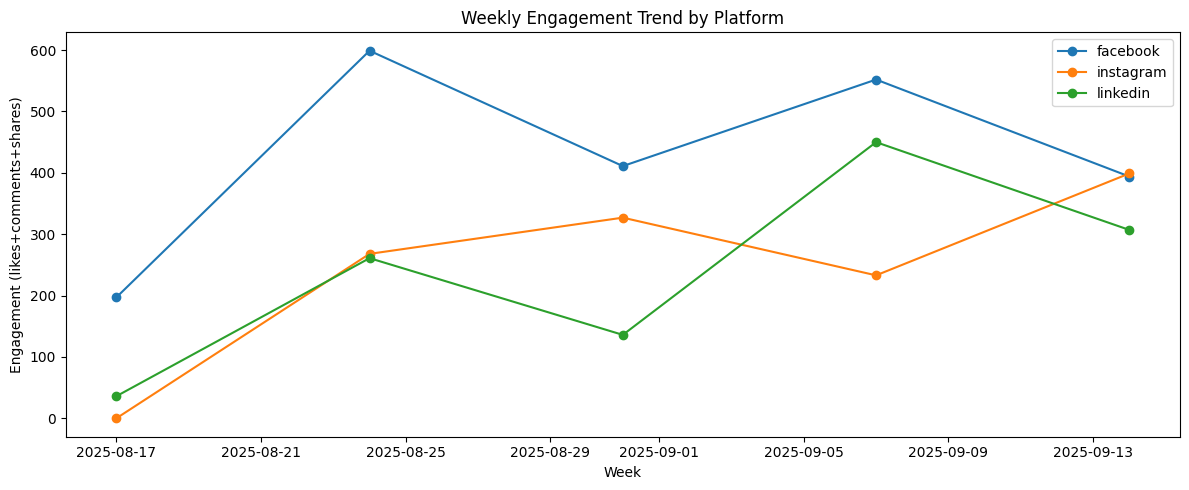

✅ Engagement Heatmap:


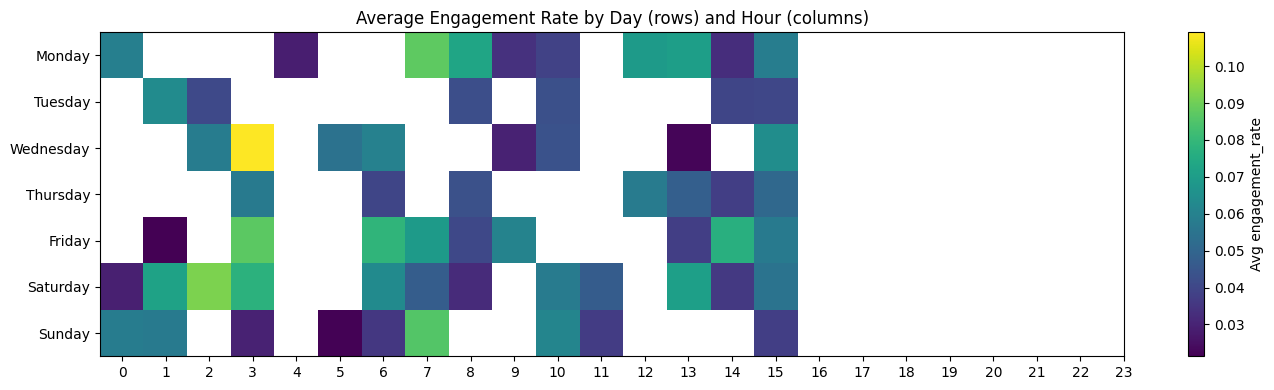

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,21,22,23
dow,,,,,,,,,,,,,,,,
Monday,0.059299,NaN,NaN,NaN,0.028902,NaN,NaN,0.087362,0.073005,0.033837,0.038600,NaN,0.069337,0.070755,0.032702,0.058438
Tuesday,NaN,0.063583,0.040763,NaN,NaN,NaN,NaN,NaN,0.042496,NaN,0.042667,NaN,NaN,NaN,0.039890,0.040030
Wednesday,NaN,NaN,0.058240,0.109170,NaN,0.054341,0.059829,NaN,NaN,0.029727,0.043478,NaN,NaN,0.022539,NaN,0.064353
Thursday,NaN,NaN,NaN,0.057051,NaN,NaN,0.039636,NaN,0.043068,NaN,NaN,NaN,0.057807,0.048122,0.037625,0.050992
Friday,NaN,0.021374,NaN,0.087045,NaN,NaN,0.078947,0.069374,0.040377,0.060777,NaN,NaN,NaN,0.037821,0.076621,0.057218
Saturday,0.029013,0.071829,0.091926,0.077626,NaN,NaN,0.063503,0.047158,0.032022,NaN,0.057900,0.046832,NaN,0.070986,0.035842,0.054662
Sunday,0.058173,0.057592,NaN,0.029830,NaN,0.021739,0.035443,0.085824,NaN,NaN,0.061218,0.036823,NaN,NaN,NaN,0.037658


In [34]:
# 1. Normalize data
df = normalize_and_engineer(df)

# 2. Preview
print("✅ Dataset shape:", df.shape)
print(df.head(), "\n")

# 3. Platform summary
print("✅ Platform Summary:")
print(platform_summary(df), "\n")

# 4. Top posts
print("✅ Top Posts:")
print(top_posts(df), "\n")

# 5. Weekly trend plot
print("✅ Weekly Trend Plot:")
weekly_trend_plot(df)

# 6. Engagement heatmap
print("✅ Engagement Heatmap:")
heatmap_day_hour(df)

# Recommendations

In [35]:
# What I do: create simple, evidence-based recommendations based on analysis results

In [36]:
def generate_recommendations(df: pd.DataFrame) -> List[str]:
    recs = []
    summary = platform_summary(df)

    # Best platform by avg engagement rate
    best_platform = summary.loc[summary['avg_engagement_rate'].idxmax()]
    recs.append(
        f"Focus more on {best_platform['platform'].title()}: it has the highest average engagement rate ({best_platform['avg_engagement_rate']:.3f})."
    )

    # Best day/hour
    pivot = df.pivot_table(
        index='dow',
        columns='hour',
        values='engagement_rate',
        aggfunc='mean'
    ).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    # find index of max
    max_loc = np.unravel_index(np.nanargmax(pivot.values), pivot.shape)
    best_day = pivot.index[max_loc[0]]
    best_hour = pivot.columns[max_loc[1]]
    recs.append(
        f"Post more around {best_day}s at approx hour {best_hour}: this day/hour shows highest avg engagement rate in the data."
    )

    # Content type (media_type) recommendation if available
    if 'media_type' in df.columns:
        media_perf = df.groupby('media_type').agg(
            avg_engagement_rate=('engagement_rate', 'mean'),
            total_eng=('engagement', 'sum')
        ).sort_values('avg_engagement_rate', ascending=False)
        top_media = media_perf.index[0]
        recs.append(
            f"Try more {top_media} content — it has the best engagement rate among media types in this dataset."
        )

    # Low reach but high engagement = amplify
    low_reach_high_eng = df[
        (df['reach'] < df['reach'].quantile(0.25)) &
        (df['engagement_rate'] > df['engagement_rate'].quantile(0.75))
    ]
    if not low_reach_high_eng.empty:
        recs.append(
            "Some posts have high engagement rate but low reach — consider boosting these posts (paid) to increase exposure."
        )

    # Frequency suggestion
    posts_per_week = df.set_index('created_time').resample('W')['post_id'].count().mean()
    recs.append(
        f"Current posting frequency appears to be ~{posts_per_week:.1f} posts per week. "
        "Consider A/B testing small increases (e.g., +1 post/week) on top-performing platforms to test uplift."
    )

    return recs

# Save outputs

In [37]:
def save_outputs(df: pd.DataFrame, summary: pd.DataFrame, top_df: pd.DataFrame, out_dir: str = 'outputs'):
    os.makedirs(out_dir, exist_ok=True)
    df.to_csv(os.path.join(out_dir, 'all_posts_normalized.csv'), index=False)
    summary.to_csv(os.path.join(out_dir, 'platform_summary.csv'), index=False)
    top_df.to_csv(os.path.join(out_dir, 'top_posts.csv'), index=False)
    print(f"Saved CSV outputs to {out_dir}/")


# ---------------------------
# Main pipeline
# ---------------------------
# What I do: try to fetch from APIs. If that yields no data, generate and use demo dataset.
# Why: ensures assignment deliverables can be produced even without API access (instructor often accepts demo + API-ready code)

def main():
    print("\n=== Social Media Performance Analysis — beginning pipeline ===\n")

    # 1) Attempt API fetch (only if credentials are provided)
    facebook_df = pd.DataFrame()
    instagram_df = pd.DataFrame()
    linkedin_df = pd.DataFrame()

In [38]:
# Facebook (Instagram actually, since you’re using IG_USER_ID)
try:
    if IG_USER_ID and IG_ACCESS_TOKEN:
        print("Attempting to fetch Instagram media...")
        ig_media = fetch_instagram_media(IG_USER_ID, IG_ACCESS_TOKEN, limit=50)
        if not ig_media.empty:
            # Try to pull insights for each media where possible
            rows = []
            for _, m in ig_media.iterrows():
                # Try to get reach/impressions via insights (requires permissions)
                ins = fetch_instagram_media_insights(m['post_id'], IG_ACCESS_TOKEN, ['impressions', 'reach', 'engagement'])
                rows.append({
                    'platform': 'instagram',
                    'post_id': m['post_id'],
                    'created_time': m['created_time'],
                    'message': m.get('message'),
                    'permalink': m.get('permalink'),
                    'likes': m.get('likes'),
                    'comments': m.get('comments'),
                    'shares': 0,
                    'reach': ins.get('reach') or ins.get('impressions')
                })
            instagram_df = pd.DataFrame(rows)
    else:
        print("Skipping Instagram API fetch (no credentials set).")
except Exception as e:
    print(f"Instagram fetch error: {e}")


# LinkedIn
try:
    if LINKEDIN_ORG_URN and LINKEDIN_ACCESS_TOKEN:
        print("Attempting to fetch LinkedIn posts...")
        ln_posts = fetch_linkedin_org_posts(LINKEDIN_ORG_URN, LINKEDIN_ACCESS_TOKEN)
        if not ln_posts.empty:
            rows = []
            for _, p in ln_posts.iterrows():
                # if we have an activity urn try socialActions
                sa = fetch_linkedin_social_actions(p['post_id'], LINKEDIN_ACCESS_TOKEN)
                rows.append({
                    'platform': 'linkedin',
                    'post_id': p['post_id'],
                    'created_time': p.get('created_time'),
                    'message': p.get('message'),
                    'permalink': p.get('permalink'),
                    'likes': sa.get('likeCount'),
                    'comments': sa.get('commentCount'),
                    'shares': 0,
                    'reach': None
                })
            linkedin_df = pd.DataFrame(rows)
    else:
        print("Skipping LinkedIn API fetch (no credentials set).")
except Exception as e:
    print(f"LinkedIn fetch error: {e}")

Skipping Instagram API fetch (no credentials set).
Skipping LinkedIn API fetch (no credentials set).


In [40]:
# Initialize empty DataFrames in case API calls fail
facebook_df = pd.DataFrame()
instagram_df = pd.DataFrame()
linkedin_df = pd.DataFrame()

In [42]:
import os

# Make sure "outputs" folder exists
os.makedirs("outputs", exist_ok=True)

No API data found or fetch skipped. Generating demo dataset to run the full analysis.

Platform summary:
    platform  total_engagement  avg_engagement_rate  num_posts    avg_reach
0   facebook              2845             0.043960         50  1269.480000
1  instagram              1866             0.069714         32   818.906250
2   linkedin              1535             0.052562         38   740.789474

Top 10 posts by engagement rate:
 platform  post_id               created_time                            message  likes  comments  shares  reach  engagement  engagement_rate permalink
instagram  demo_75 2025-08-23 04:27:22.806650  Demo post 75 on instagram (video)    127        27       9   1170         163         0.139316      None
instagram demo_106 2025-09-07 21:56:22.806650 Demo post 106 on instagram (video)     52         8       3    542          63         0.116236      None
instagram  demo_90 2025-08-31 01:12:22.806650  Demo post 90 on instagram (video)     83        18    

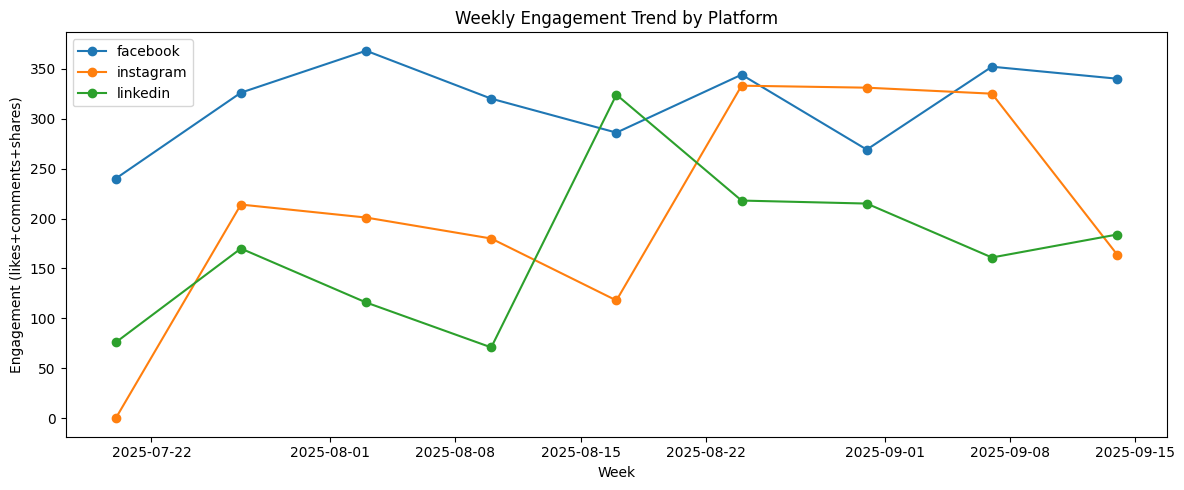

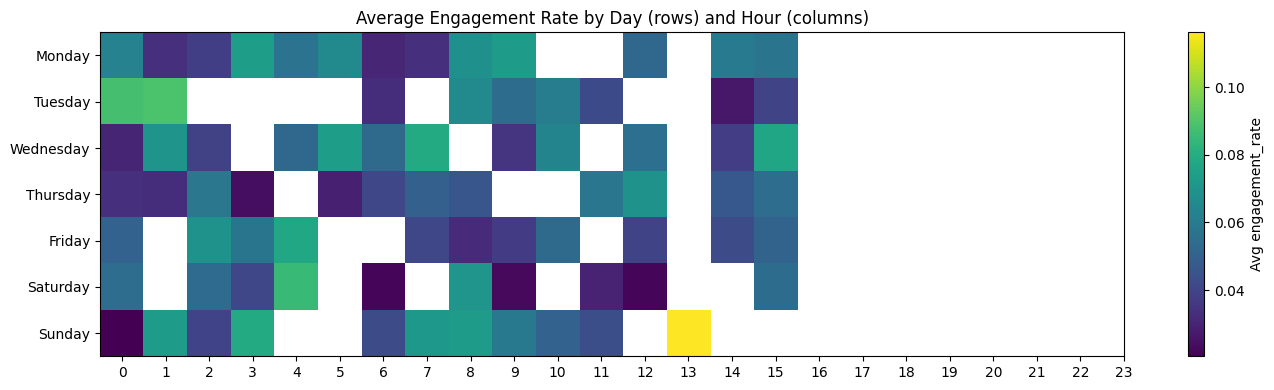


Automated recommendations:
- Focus more on Instagram: it has the highest average engagement rate (0.070).
- Post more around Sundays at approx hour 21: this day/hour shows highest avg engagement rate in the data.
- Try more video content — it has the best engagement rate among media types in this dataset.
- Some posts have high engagement rate but low reach — consider boosting these posts (paid) to increase exposure.
- Current posting frequency appears to be ~13.3 posts per week. Consider A/B testing small increases (e.g., +1 post/week) on top-performing platforms to test uplift.
Saved CSV outputs to outputs/

=== Pipeline complete. Check outputs/ folder for CSVs and generated plots. ===


=== Social Media Performance Analysis — beginning pipeline ===



In [43]:
# 2) Combine API dataframes (if any)
combined_api_df = pd.concat(
    [facebook_df, instagram_df, linkedin_df],
    ignore_index=True,
    sort=False
) if (not facebook_df.empty or not instagram_df.empty or not linkedin_df.empty) else pd.DataFrame()

# If no API data found, create demo dataset
if combined_api_df.empty:
    print("No API data found or fetch skipped. Generating demo dataset to run the full analysis.")
    df = create_demo_dataset(n_days=60, posts_per_day=2)
else:
    print("API data found. Proceeding with normalization and analysis.")
    df = combined_api_df

# 3) Normalize & feature engineer
df_norm = normalize_and_engineer(df)

# 4) Analysis outputs
print("\nPlatform summary:")
summary = platform_summary(df_norm)
print(summary)

print("\nTop 10 posts by engagement rate:")
tp = top_posts(df_norm, n=10)
print(tp.to_string(index=False))

# 5) Plots
weekly_trend_plot(df_norm, savepath='outputs/weekly_trend.png')
pivot = heatmap_day_hour(df_norm, savepath='outputs/heatmap_day_hour.png')

# 6) Recommendations
recs = generate_recommendations(df_norm)
print("\nAutomated recommendations:")
for r in recs:
    print(f"- {r}")

# 7) Save outputs
save_outputs(df_norm, summary, tp, out_dir='outputs')

print("\n=== Pipeline complete. Check outputs/ folder for CSVs and generated plots. ===\n")


if __name__ == '__main__':
    main()